In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})

import os
import pickle

import time

In [2]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [3]:
from cpymad.madx import Madx

import sixtracklib as pyst
import pysixtrack

In [4]:
# import sys
# sys.path.append('/home/oeftiger/gsi/git/python3/PyHEADTAIL/')
# from PyHEADTAIL.particles import generators

# VERSIONING

## SixTrackLib:

In [5]:
pyst.__file__

'/home/oeftiger/gsi/git/sixtracklib/python/sixtracklib/__init__.py'

In [6]:
!cd /home/oeftiger/gsi/git/sixtracklib/python/ && git log | head -4

commit 0539914c228a66820427b2c7d333725fcc02ebd7
Merge: 00d1a3a7 af5af8ea
Author: Martin Schwinzerl <martin.schwinzerl@cern.ch>
Date:   Mon Dec 16 19:05:33 2019 +0100


## PySixTrack:

In [7]:
pysixtrack.__file__

'/home/oeftiger/gsi/git/pysixtrack/pysixtrack/__init__.py'

In [8]:
!cd /home/oeftiger/gsi/git/pysixtrack/ && git log | head -4

commit 3429831a7a2a578213f8bb7f1de3792715dad2bd
Author: Riccardo De Maria <riccardodemaria@gmail.com>
Date:   Wed Dec 18 18:04:48 2019 +0100



# Parameters

In [9]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
# nmass = 0.931494061 # MAD-X value

In [10]:
tune_range_qx = np.arange(18.55, 18.95 + 0.01, 0.01)
tune_range_qy = tune_range_qx

In [11]:
nturns = 20000 #2**16
npart = 1#000

A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)


In [12]:
epsx_rms_fin = 35e-6 / 4 # geometrical emittances
epsy_rms_fin = 15e-6 / 4

limit_n_rms_x = 2
limit_n_rms_y = 2
limit_n_rms_z = 3.4

sig_z = 58 / 4. # in m
sig_dp = 0.5e-3

###

epsx_gauss = epsx_rms_fin * 1.778
epsy_gauss = epsy_rms_fin * 1.82

epsn_x = epsx_gauss * beta * gamma
epsn_y = epsy_gauss * beta * gamma

beta_z = sig_z / sig_dp

# 1. no errors, no aperture $Q_x=.55, Q_y=.55$

In [13]:
filename_tracksumm = (
    '../../../../vera_sc/noSC_errors/2019-12-17--noerr-comparison-losses/'
    'noerr_noaper_55_55/55_55/track_55_55_1_20000_.obs0001.p0001'
)

In [14]:
filename_tracksumm = 'track_55_55_1_20000_.obs0001.p0001'

headers = list(np.genfromtxt(
    filename_tracksumm, skip_header=6, max_rows=1, dtype=str)[1:])

initial_distribution_madx = np.genfromtxt(
    filename_tracksumm, skip_header=8, max_rows=1, dtype=np.float64)

p_all = np.genfromtxt(
    filename_tracksumm, skip_header=8, dtype=np.float64)

In [15]:
def get_betai(PT, mass=mass, p0=p0):
    restmass = mass * c**2
    restmass_sq = restmass**2
    E0 = np.sqrt((p0 * c)**2 + restmass_sq)
    
    E = E0 + PT * p0 * c
    gammai = E / restmass
    betai = np.sqrt(1 - 1. / (gammai * gammai))
    return betai

In [16]:
# e_seed = 1

qx = 18.55 #tune_range_qx[0]
qy = 18.55 #tune_range_qy[0]
install_apertures = False
apply_errors = False

pystl_device = "opencl:0.0"

qqx, qqy = int(np.round((qx%1) * 100)), int(np.round((qy%1) * 100))

# filename_error_table = "./error_tables/errors_{qqx}_{qqy}_{eseed:d}".format(
#             qqx=qqx, qqy=qqy, eseed=e_seed)

madx = Madx()
madx.options.echo = False
madx.options.warn = False

madx.call('./SIS100_RF_220618_9slices.thin.seq')

madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot) # /Q for RF to have proton beam!

madx.call('OpticsYEH_BeamParameters.str')
madx.call('Coll+Errors+BeamDistr.madx')

madx.use(sequence='sis100ring')

### --> first match, then add errors, then TWISS!

madx.input('''
    match, sequence=SIS100RING;
    global, sequence=SIS100RING, q1={qx}, q2={qy};
    vary, name=kqf, step=0.00001;
    vary, name=kqd, step=0.00001;
    lmdif, calls=500, tolerance=1.0e-10;
    endmatch;
'''.format(qx=qx, qy=qy)
)

if apply_errors:
    madx.command.eoption(add=True, seed=1)
    madx.command.exec('EA_EFCOMP_MH()')
    for s in range(1, 10):
        assert madx.command.exec(f'EA_rEFCOMP_QD({s},1)')

twiss = madx.twiss();

if apply_errors:
    madx.command.select(flag='error', pattern='QD11..', class_='MULTIPOLE')
    madx.command.select(flag='error', pattern='QD12..', class_='MULTIPOLE')
    madx.command.select(flag='error', pattern='mh1', class_='MULTIPOLE')
    madx.command.select(flag='error', pattern='mh2', class_='MULTIPOLE')
    madx.command.esave(file=filename_error_table)

madx.input('cavity_voltage = 58.2/1000/number_cavities;')

if apply_errors:
    madx.command.readtable(file=filename_error_table, table="errors")
    errors = madx.table.errors

sis100 = madx.sequence.sis100ring

# particle initialisation from pyheadtail

# D_x_0 = twiss['dx'][0] * beta
# D_y_0 = twiss['dy'][0] * beta

# np.random.seed(0)

# pyht_beam = generators.generate_Gaussian6DTwiss(
#     1, 1, charge, mass, twiss['s'][-1], gamma,
#     twiss['alfx'][0], twiss['alfy'][0], twiss['betx'][0], twiss['bety'][0],
#     1, epsn_x, epsn_y, 1,
#     dispersion_x=D_x_0 if D_x_0 else None,
#     dispersion_y=D_y_0 if D_y_0 else None,
#     limit_n_rms_x=limit_n_rms_x**2, limit_n_rms_y=limit_n_rms_y**2, 
#     limit_n_rms_z=limit_n_rms_z**2,
# )

# distribution_z_uncut = generators.gaussian2D(
#     sig_z**2)
# is_accepted = generators.make_is_accepted_within_n_sigma(
#     epsn_rms=sig_z,
#     limit_n_rms=limit_n_rms_z,
# )
# distribution_z_cut = generators.cut_distribution(distribution_z_uncut, is_accepted)

# z, dp = distribution_z_cut(npart)
# pyht_beam.z, pyht_beam.dp = z, dp / beta_z

######### only for direct comparison here: 
######### reading in coordinates from Vera's MAD-X distribution

# betai = get_betai(initial_distribution_madx[headers.index('PT')])

# pyht_beam.x[:] = initial_distribution_madx[headers.index('X')]
# pyht_beam.xp[:] = initial_distribution_madx[headers.index('PX')]
# pyht_beam.y[:] = initial_distribution_madx[headers.index('Y')]
# pyht_beam.yp[:] = initial_distribution_madx[headers.index('PY')]
# pyht_beam.z[:] = initial_distribution_madx[headers.index('T')] * betai
# pyht_beam.dp[:] = initial_distribution_madx[headers.index('PT')] / betai

### PySixTrack, transferring particles from MAD-X

madx.command.readtable(file=filename_tracksumm, table="tracksumm")
# attention: in Vera's set-up, the ion mass is rescaled by Q

pysixtrack_particles = pysixtrack.Particles.from_madx_track(madx)

pysixtrack_particles._p0c = p0c
pysixtrack_particles._mass0 = mass / e * c**2

# pysixtrack_particles = pysixtrack.Particles.from_madx_track(madx)

# necessary to transfer to SixTrackLib with this version of PySixTrack
pysixtrack_particles.state = np.ones_like(pysixtrack_particles.x)
pysixtrack_particles.state[1:] = 0
pysixtrack_particles.elemid = 0

pysixtrack_particles.remove_lost_particles()

### PySixTrack, lattice transfer and preparation!

pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    sis100, exact_drift=True, install_apertures=install_apertures
)

pysixtrack_elements.remove_zero_length_drifts(inplace=True);
pysixtrack_elements.merge_consecutive_drifts(inplace=True);

 # add alignment and multipole errors

if apply_errors:
    pysixtrack_elements.apply_madx_errors(error_table=errors)

### Load lattice into SixTrackLib

elements = pyst.Elements.from_line(pysixtrack_elements)
elements.BeamMonitor(num_stores=nturns);

### Transfer particles into SixTrackLib

particles = pyst.ParticlesSet().Particles(num_particles=1)
particles.from_pysixtrack(pysixtrack_particles, particle_index=0)

# # attention: in Vera's set-up, the ion mass is rescaled by Q, cannot reuse p0c (delta offset!)
# particles = pyst.Particles.from_ref(npart, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

# particles.x[:] = pysixtrack_particles.x
# particles.px[:] = pysixtrack_particles.px
# particles.y[:] = pysixtrack_particles.y
# particles.py[:] = pysixtrack_particles.py
# particles.zeta[:] = pysixtrack_particles.zeta
# particles.delta[:] = pysixtrack_particles.delta


# particles.x[:] = pyht_beam.x
# particles.px[:] = pyht_beam.xp
# particles.y[:] = pyht_beam.y
# particles.py[:] = pyht_beam.yp
# particles.zeta[:] = pyht_beam.z
# particles.delta[:] = pyht_beam.dp

# # according to newest master branch of SixTrackLib, the following are not needed anymore!
# particles.rpp[:] = 1. / (pyht_beam.dp + 1)

# restmass = mass * c**2
# restmass_sq = restmass**2
# E0 = np.sqrt((p0 * c)**2 + restmass_sq)
# p = p0 * (1 + pyht_beam.dp)
# E = np.sqrt((p * c)**2 + restmass_sq)
# particles.psigma[:] = (E - E0) / (beta * p0 * c)

# gammai = E / restmass
# betai = np.sqrt(1 - 1. / (gammai * gammai))
# particles.rvv[:] = betai / beta

### prepare trackjob in SixTrackLib

# trackjob = pyst.TrackJob(elements, particles)
trackjob = pyst.TrackJob(elements, particles, device=pystl_device)

print ('\n\n\n' + '+'*26 + '\n*** ready for tracking ***\n' + '+'*26 + '\n')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.01.03 18:36:59      +
  ++++++++++++++++++++++++++++++++++++++++++++
START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   2.51152721e-15





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.77739e-01  2.81571e-01 -1.00000e+20  1.00000e+20
kqd                      -2.77252e-01 -2.80616e-01 -1.00000e+20  1.

In [17]:
t0 = time.time()

trackjob.track_until(nturns)
trackjob.collect()

# store = {}
# filename_error_table = os.path.basename(filename_error_table)

# # statistics
# x = trackjob.output.particles[0].x.reshape((nturns, npart)).T
# store['std_x'] = np.mean(np.std(x, axis=0)[-50:])
# y = trackjob.output.particles[0].y.reshape((nturns, npart)).T
# store['std_y'] = np.mean(np.std(y, axis=0)[-50:])

# # losses
# pbuffer = trackjob.particles_buffer.get_object(0)
# np.save('results/' + filename_error_table + '_alive.npy', pbuffer.state)
# np.save('results/' + filename_error_table + '_lost_at_element.npy', 
#         pbuffer.at_element[~pbuffer.state.astype(bool)])
# np.save('results/' + filename_error_table + '_lost_at_turn.npy',
#         pbuffer.at_turn[~pbuffer.state.astype(bool)])

# store['losses'] = np.sum(pbuffer.state)

# # finish job
# pickle.dump(store, open('results/' + filename_error_table + '_summary.p', 'wb'))

# !touch "results/$filename_error_table"_done

# del trackjob, elements, particles

t1 = time.time()

In [18]:
(t1 - t0) / 60.

1.1790087819099426

In [19]:
pbuffer = trackjob.particles_buffer.get_object(0)

In [20]:
np.sum(pbuffer.state)

1

In [21]:
x = trackjob.output.particles[0].x
px = trackjob.output.particles[0].px
y = trackjob.output.particles[0].y
py = trackjob.output.particles[0].py
zeta = trackjob.output.particles[0].zeta
delta = trackjob.output.particles[0].delta

(10000, 10100)

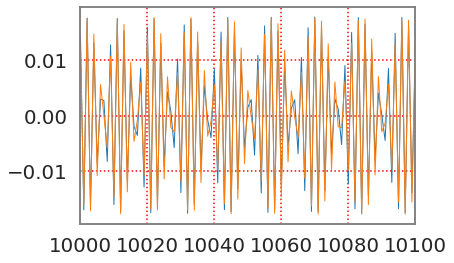

In [22]:
plt.plot(x[0::npart], lw=1)
plt.plot(p_all[1:, headers.index('X')], lw=1)
# plt.xlim(0, 10)
plt.xlim(10000, 10100)

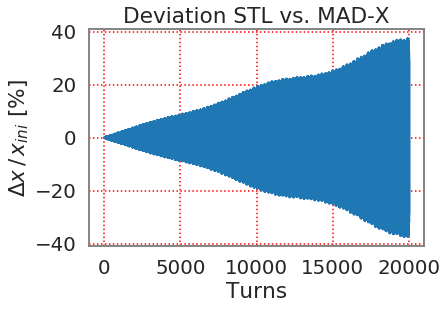

In [23]:
plt.plot((x[0::npart] - p_all[1:, headers.index('X')]) / x[0] * 100)
plt.xlabel('Turns')
plt.ylabel(r'$\Delta x \,/\, x_{ini}$ [%]')
plt.title('Deviation STL vs. MAD-X');

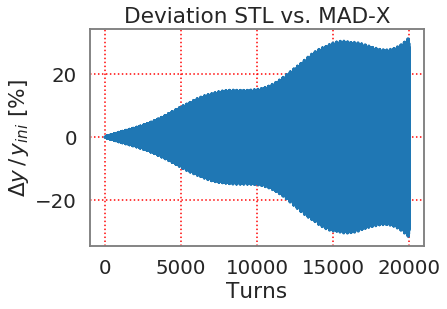

In [24]:
plt.plot((y[0::npart] - p_all[1:, headers.index('Y')]) / y[0] * 100)
plt.xlabel('Turns')
plt.ylabel(r'$\Delta y \,/\, y_{ini}$ [%]')
plt.title('Deviation STL vs. MAD-X');

In [25]:
zeta_madx = p_all[1:, headers.index('T')] * get_betai(p_all[1:, headers.index('PT')])

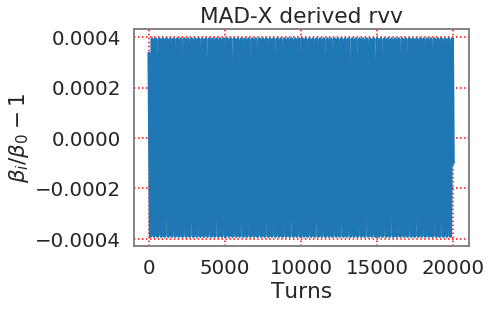

In [26]:
plt.plot(get_betai(p_all[1:, headers.index('PT')]) / beta - 1)
plt.xlabel('Turns')
plt.ylabel(r'$\beta_i / \beta_0 - 1$')
plt.title('MAD-X derived rvv');

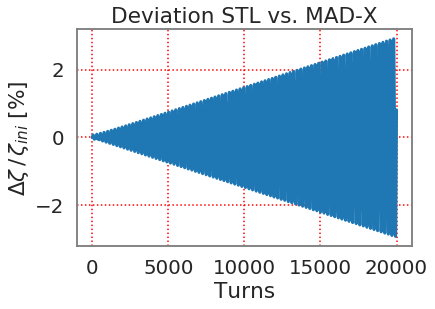

In [27]:
plt.plot(
    (zeta[0::npart] - zeta_madx) / zeta[0] * 100)
plt.xlabel('Turns')
plt.ylabel(r'$\Delta \zeta \,/\, \zeta_{ini}$ [%]')
plt.title('Deviation STL vs. MAD-X');

In [28]:
delta_madx = p_all[1:, headers.index('PT')] / get_betai(p_all[1:, headers.index('PT')])

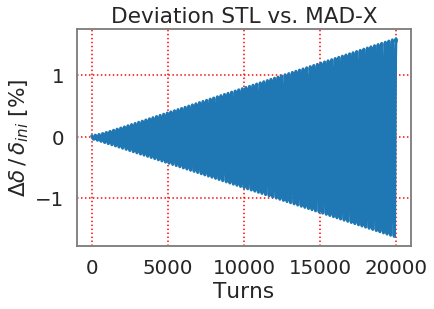

In [29]:
plt.plot((delta[0::npart] - delta_madx) / delta[0] * 100)
plt.xlabel('Turns')
plt.ylabel(r'$\Delta \delta \,/\, \delta_{ini}$ [%]')
plt.title('Deviation STL vs. MAD-X');
# plt.xlim(0, 100)
# plt.ylim(-1e-6, 1e-6)

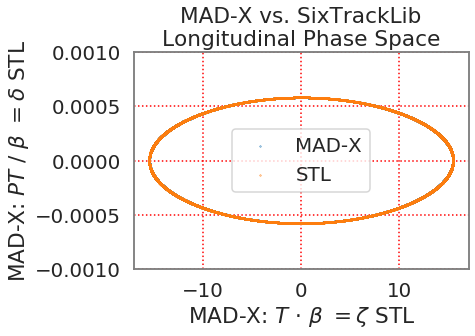

In [30]:
plt.scatter(zeta_madx, 
            delta_madx,
            marker='.', s=1, label='MAD-X')
plt.scatter(zeta, 
            delta,
            marker='.', s=1, label='STL')
plt.legend()
plt.ylim(-1e-3, 1e-3);
plt.xlabel(r'MAD-X: $T$ $\cdot$ $\beta$ $=\zeta$ STL')
plt.ylabel(r'MAD-X: $PT$ $/$ $\beta$ $=\delta$ STL');
plt.title('MAD-X vs. SixTrackLib\nLongitudinal Phase Space');

$\implies$ small but evident systematic difference between SixTrackLib and MAD-X for longitudinal motion included!

#### MAD-X:

In [31]:
# voltages of all SIS100 cavities:
sum([f.volt for f in sis100.expanded_elements if 'avity' in str(f.base_type)])

0.05820000000000002

In [32]:
# freq of SIS100 cavities:
[f.freq for f in sis100.expanded_elements if 'avity' in str(f.base_type)][0]

1.5705898388586776

In [33]:
# lag of SIS100 cavities:
[f.lag for f in sis100.expanded_elements if 'avity' in str(f.base_type)][0]

0.0

In [34]:
madx.input('VALUE, beam->pc;')

beam->pc           =        152.8763573 ;


True

In [35]:
# length of all SIS100 cavities:
[f.length for f in sis100.expanded_elements if 'avity' in str(f.base_type)][0]

0.0

#### SixTrackLib:

In [36]:
# voltages of all SIS100 cavities:
sum([f.voltage for f in pysixtrack_elements.elements if 'avity' in str(f)])

58199.99999999999

In [37]:
# freq of SIS100 cavities:
[f.frequency for f in pysixtrack_elements.elements if 'avity' in str(f)][0]

1570589.8388586775

In [38]:
# lag of SIS100 cavities:
[f.lag for f in pysixtrack_elements.elements if 'avity' in str(f)][0]

0.0

In [39]:
particles.p0c * 1e-9

array([152.87635728])

## reproduce data from Vera with MAD-X tracking:

add charge $Q$ factor in cavity voltage for correct longitudinal tracking in MAD-X:

In [40]:
madx.input('cavity_voltage = 58.2/1000/number_cavities * 28;')

True

In [41]:
madx.input('''
TRACK, onepass, dump, file="track_noSpch_"; !recloss,APERTURE,onetable
''' +
'''
START, x={:.20e}, px={:.20e}, y={:.20e}, py={:.20e}, t={:.20e}, pt={:.20e};
'''.format(*initial_distribution_madx[2:8]) +
'''
run, turns=20000; !turns=total_turns,ffile=ffile_stat,maxaper={1.0,1.0,1.0,1.0,1000.0,1000.0}	;
endtrack;

write,table=tracksumm,file="tracksumm_55_55_1";
!write,table=trackloss,file="trackloss_84_73_1";
'''
)

enter TRACK module
one pass is on
exit TRACK module



True

In [42]:
filename_tracksumm = (
    './track_noSpch_.obs0001.p0001' #tracksumm_55_55_1'
)

p_all_here = np.genfromtxt(
    filename_tracksumm, skip_header=8, dtype=np.float64)

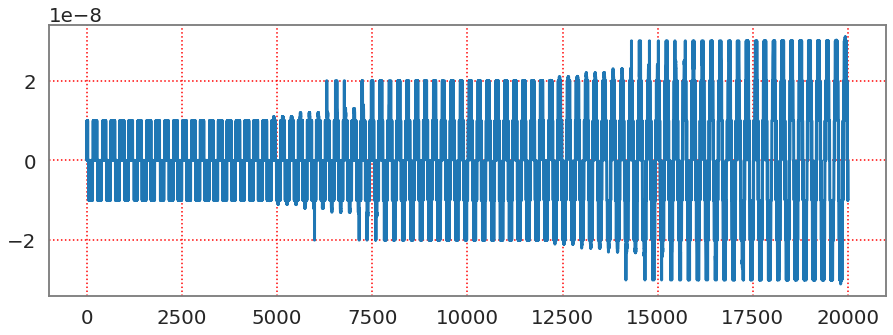

In [43]:
plt.figure(figsize=(15,5))
plt.plot(p_all_here[1:, headers.index('T')] - p_all[1:, headers.index('T')])

### What happens if I put the /Q set-up?

Vera runs with charge-1 beam and the real cavity voltage instead of scaling the voltage, for this trick to work one needs to adjust the mass to $1/Q$:

In [44]:
madx = Madx()
madx.options.echo = False
madx.options.warn = False

madx.call('./SIS100_RF_220618_9slices.thin.seq')

def Etot_div_Q():
    A = 238 / 28.
    Q = 1
    Ekin_per_nucleon = 0.2e9 # in eV
    mass = A * nmass * 1e9 * e / c**2 # in kg
    charge = Q * e # in Coul
    Ekin = Ekin_per_nucleon * A
    p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV
    Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
    return Etot

madx.command.beam(
    particle='ion', mass=A*nmass / Q, charge=Q / Q, energy=Etot_div_Q()
) # /Q for RF to have proton beam!

madx.call('OpticsYEH_BeamParameters.str')
madx.call('Coll+Errors+BeamDistr.madx')

madx.use(sequence='sis100ring')

### --> first match, then add errors, then TWISS!

madx.input('''
    match, sequence=SIS100RING;
    global, sequence=SIS100RING, q1={qx}, q2={qy};
    vary, name=kqf, step=0.00001;
    vary, name=kqd, step=0.00001;
    lmdif, calls=500, tolerance=1.0e-10;
    endmatch;
'''.format(qx=qx, qy=qy)
)

twiss = madx.twiss();


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.01.03 18:41:52      +
  ++++++++++++++++++++++++++++++++++++++++++++
START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   2.51152721e-15





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.77739e-01  2.81571e-01 -1.00000e+20  1.00000e+20
kqd                      -2.77252e-01 -2.80616e-01 -1.00000e+20  1.

In [45]:
madx.input('cavity_voltage = 58.2/1000/number_cavities;')

True

In [46]:
madx.input('''
TRACK, onepass, dump, file="track_noSpch2_"; !recloss,APERTURE,onetable
''' +
'''
START, x={:.20e}, px={:.20e}, y={:.20e}, py={:.20e}, t={:.20e}, pt={:.20e};
'''.format(*initial_distribution_madx[2:8]) +
'''
run, turns=20000; !turns=total_turns,ffile=ffile_stat,maxaper={1.0,1.0,1.0,1.0,1000.0,1000.0}	;
endtrack;

write,table=tracksumm,file="tracksumm_55_55_1";
!write,table=trackloss,file="trackloss_84_73_1";
'''
)

enter TRACK module
one pass is on
exit TRACK module



True

In [47]:
filename2_tracksumm = (
    './track_noSpch2_.obs0001.p0001' #tracksumm_55_55_1'
)

p_all_here2 = np.genfromtxt(
    filename2_tracksumm, skip_header=8, dtype=np.float64)

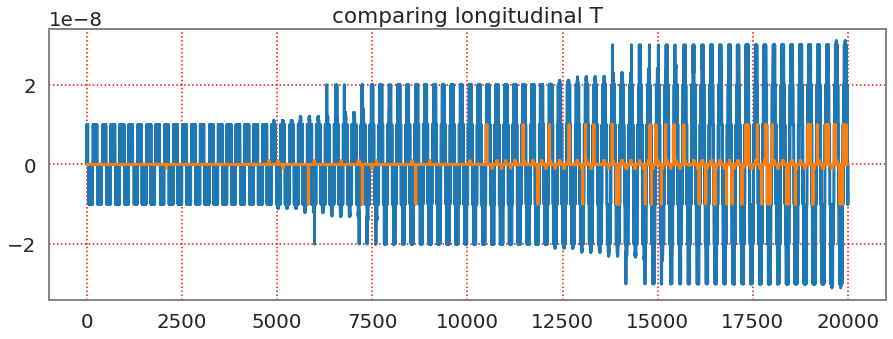

In [48]:
plt.figure(figsize=(15,5))
plt.plot(p_all_here2[1:, headers.index('T')] - p_all[1:, headers.index('T')])
plt.plot(p_all_here2[1:, headers.index('T')] - p_all_here[1:, headers.index('T')])
plt.title('comparing longitudinal T');

$\implies$ the blue curve compares this PC's MAD-X results to Vera's PC's MAD-X results.. for some obscure reason, they are $10^{-8}$ apart. 

$\implies$ the orange curve is the comparison (on this PC) between putting the charge $Q=28$ into the beam command (and rescaling the RF voltage) vs. rescaling the mass (and leaving the RF voltage at its physical value).

We do not see any difference on the $10^{-3}$ level in the longitudinal plane between both approaches! So this effect here does not explain the discrepancy to SixTrackLib!

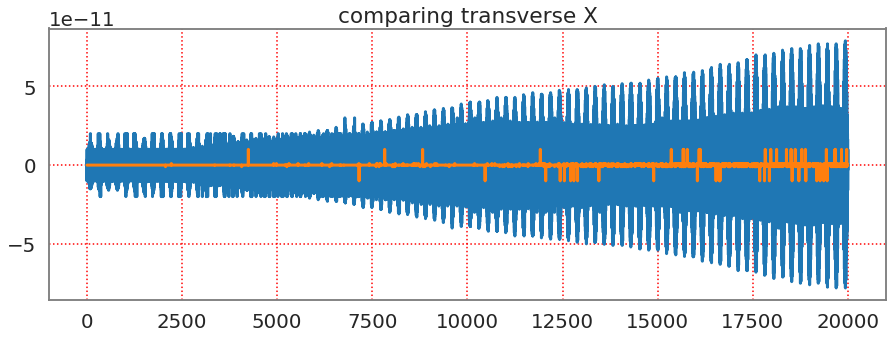

In [49]:
plt.figure(figsize=(15,5))
plt.plot(p_all_here2[1:, headers.index('X')] - p_all[1:, headers.index('X')])
plt.plot(p_all_here2[1:, headers.index('X')] - p_all_here[1:, headers.index('X')])
plt.title('comparing transverse X');

# without RF it gives the same:

In [50]:
madx.input('cavity_voltage = 0;')

True

In [51]:
madx.input('''
TRACK, onepass, dump, file="track_noSpch3_"; !recloss,APERTURE,onetable
''' +
'''
START, x={:.20e}, px={:.20e}, y={:.20e}, py={:.20e}, t=0, pt=0;
'''.format(*initial_distribution_madx[2:6]) +
'''
run, turns=20000; !turns=total_turns,ffile=ffile_stat,maxaper={1.0,1.0,1.0,1.0,1000.0,1000.0}	;
endtrack;
'''
)

enter TRACK module
one pass is on
exit TRACK module



True

In [52]:
filename3_tracksumm = (
    './track_noSpch3_.obs0001.p0001' #tracksumm_55_55_1'
)

p_all_here3 = np.genfromtxt(
    filename3_tracksumm, skip_header=8, dtype=np.float64)

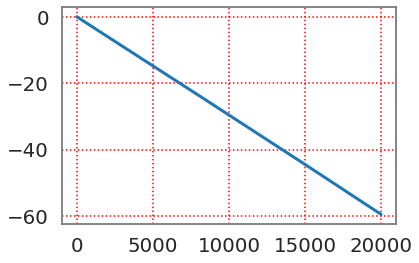

In [53]:
plt.plot(p_all_here3[1:, headers.index('T')])

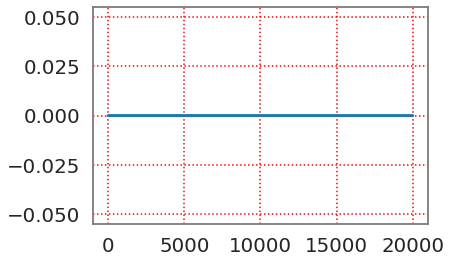

In [54]:
plt.plot(p_all_here3[1:, headers.index('PT')])

In [55]:
# voltages of all SIS100 cavities:
[f.volt for f in madx.sequence.sis100ring.expanded_elements if 'avity' in str(f.base_type)]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [56]:
del trackjob, elements, particles

### PySixTrack, lattice transfer and preparation!

pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    madx.sequence.sis100ring, exact_drift=True, install_apertures=install_apertures
)

pysixtrack_elements.remove_zero_length_drifts(inplace=True);
pysixtrack_elements.merge_consecutive_drifts(inplace=True);

 # add alignment and multipole errors

if apply_errors:
    pysixtrack_elements.apply_madx_errors(error_table=errors)

### Load lattice into SixTrackLib

elements = pyst.Elements.from_line(pysixtrack_elements)
elements.BeamMonitor(num_stores=nturns);

### Transfer particles into SixTrackLib

particles = pyst.Particles.from_ref(npart, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

particles.x[:] = initial_distribution_madx[headers.index('X')]
particles.px[:] = initial_distribution_madx[headers.index('PX')]
particles.y[:] = initial_distribution_madx[headers.index('Y')]
particles.py[:] = initial_distribution_madx[headers.index('PY')]
particles.zeta[:] = 0
particles.delta[:] = 0

# particles.rpp[:] = 1. / (pyht_beam.dp + 1)

# restmass = mass * c**2
# restmass_sq = restmass**2
# E0 = np.sqrt((p0 * c)**2 + restmass_sq)
# p = p0 * (1 + pyht_beam.dp)
# E = np.sqrt((p * c)**2 + restmass_sq)
# particles.psigma[:] = (E - E0) / (beta * p0 * c)

# gammai = E / restmass
# betai = np.sqrt(1 - 1. / (gammai * gammai))
# particles.rvv[:] = betai / beta

### prepare trackjob in SixTrackLib

# trackjob = pyst.TrackJob(elements, particles)
trackjob = pyst.TrackJob(elements, particles, device=pystl_device)

print ('\n\n\n' + '+'*26 + '\n*** ready for tracking ***\n' + '+'*26 + '\n')




++++++++++++++++++++++++++
*** ready for tracking ***
++++++++++++++++++++++++++



In [57]:
trackjob.track_until(nturns)
trackjob.collect()

In [58]:
pbuffer = trackjob.particles_buffer.get_object(0)

In [59]:
x = trackjob.output.particles[0].x
px = trackjob.output.particles[0].px
y = trackjob.output.particles[0].y
py = trackjob.output.particles[0].py
zeta = trackjob.output.particles[0].zeta
delta = trackjob.output.particles[0].delta

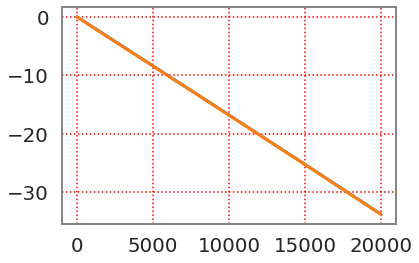

In [60]:
plt.plot(zeta)
plt.plot(p_all_here3[1:, headers.index('T')] * get_betai(p_all_here3[1:, headers.index('PT')]))

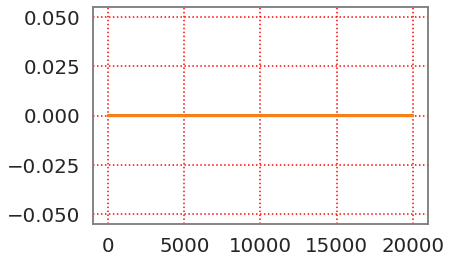

In [61]:
plt.plot(delta)
plt.plot(p_all_here3[1:, headers.index('PT')] / get_betai(p_all_here3[1:, headers.index('PT')]))

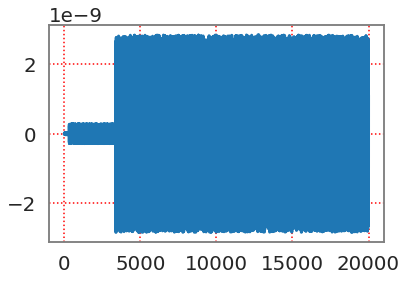

In [62]:
plt.plot(
    zeta - p_all_here3[1:, headers.index('T')] * get_betai(p_all_here3[1:, headers.index('PT')]))

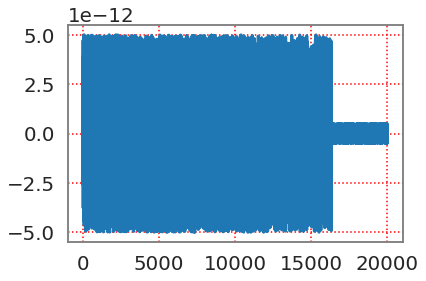

In [63]:
plt.plot(x - p_all_here3[1:, headers.index('X')])

$\implies$ RF voltage == 0 gives the SAME result between MAD-X and SixTrackLib (as established before!!) #%$£!!!

# What happens during one turn??

### MAD-X one-turn tracking

In [64]:
madx = Madx()
madx.options.echo = False
madx.options.warn = False

madx.call('./SIS100_RF_220618_9slices.thin.seq')

madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot) # /Q for RF to have proton beam!

madx.call('OpticsYEH_BeamParameters.str')
madx.call('Coll+Errors+BeamDistr.madx')

madx.use(sequence='sis100ring')

### --> first match, then add errors, then TWISS!

madx.input('''
    match, sequence=SIS100RING;
    global, sequence=SIS100RING, q1={qx}, q2={qy};
    vary, name=kqf, step=0.00001;
    vary, name=kqd, step=0.00001;
    lmdif, calls=500, tolerance=1.0e-10;
    endmatch;
'''.format(qx=qx, qy=qy)
)

twiss = madx.twiss();

madx.input('cavity_voltage = 58.2/1000/number_cavities * 28;')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.01.03 18:49:53      +
  ++++++++++++++++++++++++++++++++++++++++++++
START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   2.51152721e-15





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.77739e-01  2.81571e-01 -1.00000e+20  1.00000e+20
kqd                      -2.77252e-01 -2.80616e-01 -1.00000e+20  1.

True

In [65]:
sis100 = madx.sequence.sis100ring

In [66]:
madx.input('''
TRACK, onepass, onetable, file="track_noSpch4_"; !recloss,APERTURE
''')

for elem_name in sis100.element_names()[1:-1]:
    madx.command.observe(place=elem_name)

madx.input('''
START, x={:.20e}, px={:.20e}, y={:.20e}, py={:.20e}, t={:.20e}, pt={:.20e};
'''.format(*initial_distribution_madx[2:8])
)

madx.input('''
run, turns=1; !turns=total_turns,ffile=ffile_stat,maxaper={1.0,1.0,1.0,1.0,1000.0,1000.0}	;
endtrack;
'''
)

enter TRACK module
one pass is on
exit TRACK module



True

### SixTrackLib one-turn tracking

In [67]:
madx.input('cavity_voltage = 58.2/1000/number_cavities;')

True

In [68]:
try:
    del trackjob, elements, particles
except:
    pass

# ######### only for direct comparison here: 
# ######### reading in coordinates from Vera's MAD-X distribution

# betai = get_betai(initial_distribution_madx[headers.index('PT')])

# pyht_beam.x[:] = initial_distribution_madx[headers.index('X')]
# pyht_beam.xp[:] = initial_distribution_madx[headers.index('PX')]
# pyht_beam.y[:] = initial_distribution_madx[headers.index('Y')]
# pyht_beam.yp[:] = initial_distribution_madx[headers.index('PY')]
# pyht_beam.z[:] = initial_distribution_madx[headers.index('T')] * betai
# pyht_beam.dp[:] = initial_distribution_madx[headers.index('PT')] / betai

### PySixTrack, lattice transfer and preparation!

pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    sis100, exact_drift=True, install_apertures=install_apertures
)

# pysixtrack_elements.remove_zero_length_drifts(inplace=True);
# pysixtrack_elements.merge_consecutive_drifts(inplace=True);

 # add alignment and multipole errors

if apply_errors:
    pysixtrack_elements.apply_madx_errors(error_table=errors)

### Load lattice into SixTrackLib

elements = pyst.Elements.from_line(pysixtrack_elements)
elements.BeamMonitor(num_stores=nturns);

### Transfer particles into SixTrackLib

madx.command.readtable(file="track_noSpch4_one", table="tracksumm")

pysixtrack_particles = pysixtrack.Particles.from_madx_track(madx)

pysixtrack_particles._p0c = p0c
pysixtrack_particles._mass0 = mass / e * c**2

# necessary to transfer to SixTrackLib with this version of PySixTrack
pysixtrack_particles.state = np.ones_like(pysixtrack_particles.x)
pysixtrack_particles.state[1:] = 0
pysixtrack_particles.elemid = 0

pysixtrack_particles.remove_lost_particles()

particles = pyst.ParticlesSet().Particles(num_particles=1)
particles.from_pysixtrack(pysixtrack_particles, particle_index=0)

# particles = pyst.Particles.from_ref(npart, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

# particles.x[:] = pyht_beam.x
# particles.px[:] = pyht_beam.xp
# particles.y[:] = pyht_beam.y
# particles.py[:] = pyht_beam.yp
# particles.zeta[:] = pyht_beam.z
# particles.delta[:] = pyht_beam.dp

# particles.rpp[:] = 1. / (pyht_beam.dp + 1)

# restmass = mass * c**2
# restmass_sq = restmass**2
# E0 = np.sqrt((p0 * c)**2 + restmass_sq)
# p = p0 * (1 + pyht_beam.dp)
# E = np.sqrt((p * c)**2 + restmass_sq)
# particles.psigma[:] = (E - E0) / (beta * p0 * c)

# gammai = E / restmass
# betai = np.sqrt(1 - 1. / (gammai * gammai))
# particles.rvv[:] = betai / beta

### prepare trackjob in SixTrackLib

# trackjob = pyst.TrackJob(elements, particles)
trackjob = pyst.TrackJob(elements, particles, device=pystl_device, until_turn_elem_by_elem=True)

print ('\n\n\n' + '+'*26 + '\n*** ready for tracking ***\n' + '+'*26 + '\n')

Want to make named table: tracksumm



++++++++++++++++++++++++++
*** ready for tracking ***
++++++++++++++++++++++++++



In [69]:
trackjob.track_elem_by_elem(1)
trackjob.collect()

### evaluation

In [70]:
madx_ebye = np.genfromtxt('./track_noSpch4_one', skip_header=54)
madx_ebye_headers = list(np.genfromtxt(
    './track_noSpch4_one', skip_header=51, max_rows=1, dtype=str)[1:])
madx_ebye_elems = madx_ebye.reshape((len(sis100.elements), npart, madx_ebye.shape[1]))

s_madx = madx_ebye_elems[:, 0, madx_ebye_headers.index('S')]
t_madx = madx_ebye_elems[:, 0, madx_ebye_headers.index('T')]
pt_madx = madx_ebye_elems[:, 0, madx_ebye_headers.index('PT')]

In [71]:
s = trackjob.output.particles[0].s

x = trackjob.output.particles[0].x
px = trackjob.output.particles[0].px
y = trackjob.output.particles[0].y
py = trackjob.output.particles[0].py
zeta = trackjob.output.particles[0].zeta
delta = trackjob.output.particles[0].delta
ptau = trackjob.output.particles[0].ptau

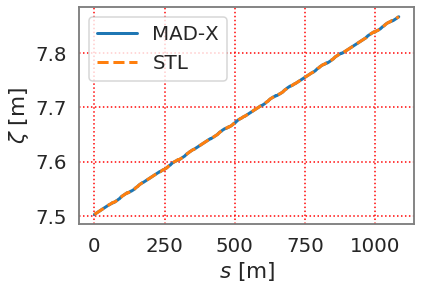

In [72]:
plt.plot(s_madx, t_madx * get_betai(pt_madx), label='MAD-X')
plt.plot(s[1::2], zeta[1::2], ls='--', label='STL')
plt.xlabel('$s$ [m]')
plt.ylabel(r'$\zeta$ [m]')
plt.legend();

In the computation of `get_betai` there is an error somewhere:

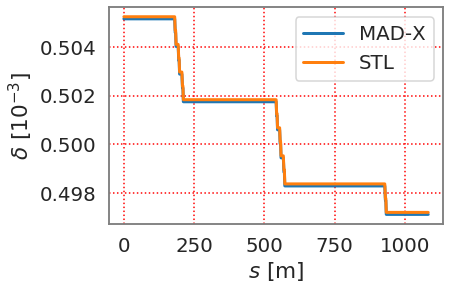

In [73]:
plt.plot(s_madx, 1e3*pt_madx / get_betai(pt_madx), label='MAD-X')
plt.plot(s[1::2], 1e3*delta[1::2], label='STL')
plt.xlabel('$s$ [m]')
plt.ylabel(r'$\delta$ [$10^{-3}$]')
plt.legend();

By avoiding `get_betai` we can directly compare ptau and PT:

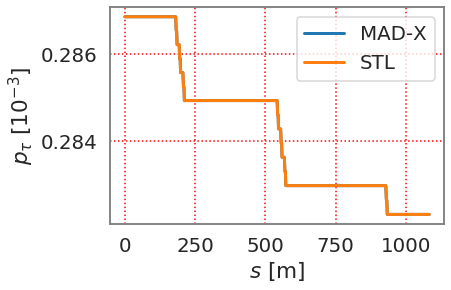

In [74]:
plt.plot(s_madx, 1e3*pt_madx, label='MAD-X')
plt.plot(s[1::2], 1e3*ptau[1::2], label='STL')
plt.xlabel('$s$ [m]')
plt.ylabel(r'$p_\tau$ [$10^{-3}$]')
plt.legend();

In [75]:
ds_min = np.min(np.diff(s_madx)[np.nonzero(np.diff(s_madx))])
s_interp = np.arange(0, min(s_madx[-1], s[-1]), ds_min)

zeta_madx_interp = np.interp(s_interp, s_madx, t_madx * get_betai(pt_madx))
zeta_stl_interp = np.interp(s_interp, s[1::2], zeta[1::2])

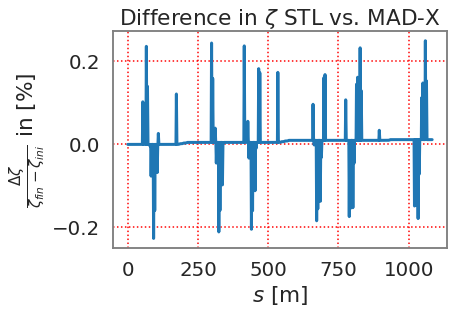

In [76]:
plt.plot(s_interp, 100 * (zeta_stl_interp - zeta_madx_interp) / (zeta_madx_interp[-1] - zeta_madx_interp[0]))
# plt.axhline((particles.rvv - 1) * 100, color='red')
plt.xlabel('$s$ [m]')
plt.ylabel(r'$\frac{\Delta\zeta}{\zeta_{fin} - \zeta_{ini}}$ in [%]')
plt.title(r'Difference in $\zeta$ STL vs. MAD-X');

/home/oeftiger/anaconda3/envs/stl_martin/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/oeftiger/anaconda3/envs/stl_martin/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


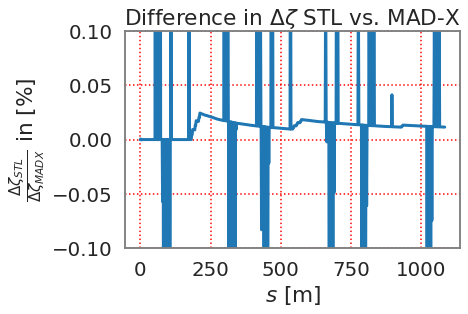

In [77]:
plt.plot(s_interp, 100 * (
    (zeta_stl_interp - zeta_stl_interp[0]) / (zeta_madx_interp - zeta_madx_interp[0]) - 1) )
# plt.axhline((particles.rvv - 1) * 100, color='red')
# plt.text(-30, 0.03, r'$\frac{\beta_i}{\beta_0}=%.5f$'%(particles.rvv), color='red', 
#          fontsize=28, va='top', bbox=dict(facecolor='white', alpha=0.8))
plt.ylim(-0.1, 0.1)
plt.xlabel('$s$ [m]')
plt.ylabel(r'$\frac{\Delta\zeta_{STL}}{\Delta\zeta_{MADX}}$ in [%]')
plt.title(r'Difference in $\Delta\zeta$ STL vs. MAD-X');

$\implies$ this longitudinal impact of the drift was not seen in the study of the exact drift difference (2019-08-21) because the longitudinal coordinates were set to 0 (cf. https://github.com/aoeftiger/sixtracklib_pyht_playground/blob/master/sis100/2019-05-24--100turns-onlyquad/beam-distr.madx)

### run this in PySixTrack

In [78]:
madx.input('cavity_voltage = 58.2/1000/number_cavities;')

True

In [79]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    madx.sequence.sis100ring, exact_drift=True, install_apertures=install_apertures
)

In [80]:
# pysixtrack_particles = pysixtrack.Particles(npart, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

# assert npart == 1
# pysixtrack_particles.x = pyht_beam.x[0]
# pysixtrack_particles.px = pyht_beam.xp[0]
# pysixtrack_particles.y = pyht_beam.y[0]
# pysixtrack_particles.py = pyht_beam.yp[0]
# pysixtrack_particles.zeta = pyht_beam.z[0]
# pysixtrack_particles.delta = pyht_beam.dp[0]
# # all other coordinates are correctly set in PySixTrack

madx.command.readtable(file="track_noSpch4_one", table="tracksumm")

pysixtrack_particles = pysixtrack.Particles.from_madx_track(madx)

Want to make named table: tracksumm


In [81]:
# pysixtrack_particles._p0c = p0c
# pysixtrack_particles._mass0 = mass / e * c**2

# necessary to transfer to SixTrackLib with this version of PySixTrack
pysixtrack_particles.state = np.ones_like(pysixtrack_particles.x)
pysixtrack_particles.state[1:] = 0
pysixtrack_particles.elemid = 0

pysixtrack_particles.remove_lost_particles()

In [82]:
pysixtrack_particles_frommadx = pysixtrack_particles

In [83]:
pysixtrack_particles = pysixtrack.Particles(npart, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

assert npart == 1
pysixtrack_particles.x = pysixtrack_particles_frommadx.x
pysixtrack_particles.px = pysixtrack_particles_frommadx.px
pysixtrack_particles.y = pysixtrack_particles_frommadx.y
pysixtrack_particles.py = pysixtrack_particles_frommadx.py
pysixtrack_particles.zeta = pysixtrack_particles_frommadx.zeta
pysixtrack_particles.delta = pysixtrack_particles_frommadx.delta

In [84]:
out = pysixtrack_elements.track_elem_by_elem(pysixtrack_particles)

In [85]:
s_pysixtrack = np.vectorize(lambda a: np.float64(a.s))(out) - 1
zeta_pysixtrack = np.vectorize(lambda a: np.float64(a.zeta))(out)
delta_pysixtrack = np.vectorize(lambda a: np.float64(a.delta))(out)

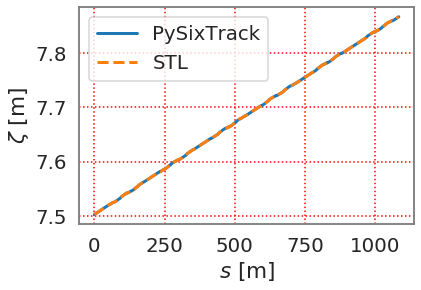

In [86]:
plt.plot(s_pysixtrack[1::2], zeta_pysixtrack[1::2], label='PySixTrack')
plt.plot(s[1::2], zeta[1::2], ls='--', label='STL')
plt.xlabel('$s$ [m]')
plt.ylabel(r'$\zeta$ [m]')
plt.legend();

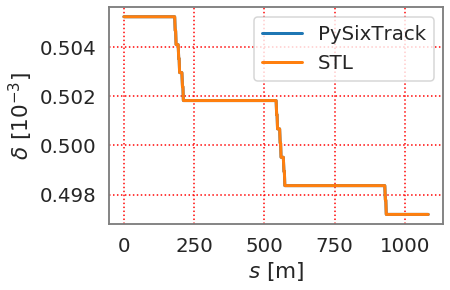

In [87]:
plt.plot(s_pysixtrack[1::2], 1e3*delta_pysixtrack[1::2], label='PySixTrack')
plt.plot(s[1::2], 1e3*delta[1::2], label='STL')
plt.xlabel('$s$ [m]')
plt.ylabel(r'$\delta$ [$10^{-3}$]')
plt.legend();

/home/oeftiger/anaconda3/envs/stl_martin/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


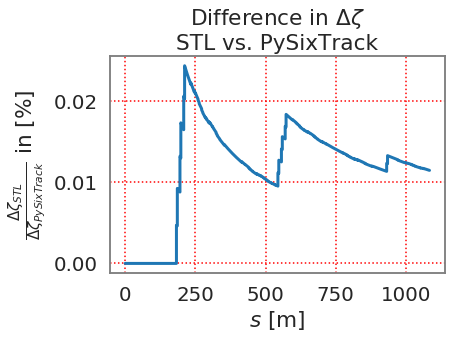

In [88]:
assert np.allclose(s_pysixtrack, s)
plt.plot(s, 100 * (
    (zeta - zeta[0]) / (zeta_pysixtrack - zeta_pysixtrack[0]) - 1) )
# plt.ylim(-0.01, 0.1)
plt.xlabel('$s$ [m]')
plt.ylabel(r'$\frac{\Delta\zeta_{STL}}{\Delta\zeta_{PySixTrack}}$ in [%]')
plt.title(r'Difference in $\Delta\zeta$' + '\nSTL vs. PySixTrack');

/home/oeftiger/anaconda3/envs/stl_martin/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


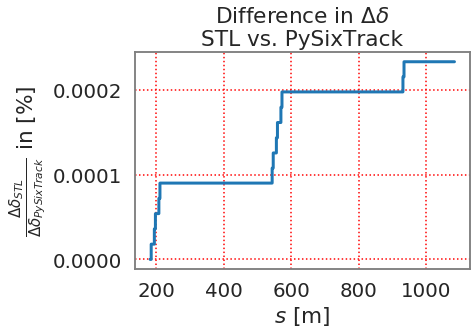

In [89]:
assert np.allclose(s_pysixtrack, s)
plt.plot(s, 100 * (
    (delta - delta[0]) / (delta_pysixtrack - delta_pysixtrack[0]) - 1) )
# plt.xlim(-100, 0.1)
plt.xlabel('$s$ [m]')
plt.ylabel(r'$\frac{\Delta\delta_{STL}}{\Delta\delta_{PySixTrack}}$ in [%]')
plt.title(r'Difference in $\Delta\delta$' + '\nSTL vs. PySixTrack');

/home/oeftiger/anaconda3/envs/stl_martin/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


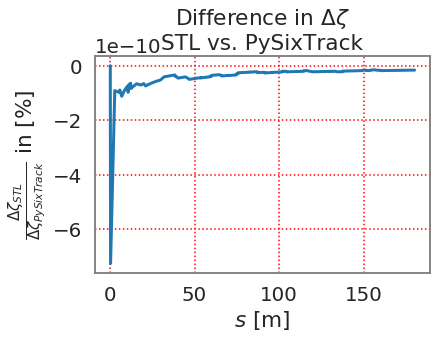

In [90]:
assert np.allclose(s_pysixtrack, s)
id_s_before_rf = np.argmax(s>180)

plt.plot(s[:id_s_before_rf], 100 * (
    (zeta - zeta[0]) / (zeta_pysixtrack - zeta_pysixtrack[0]) - 1)[:id_s_before_rf] )
# plt.ylim(-0.01, 0.1)
plt.xlabel('$s$ [m]')
plt.ylabel(r'$\frac{\Delta\zeta_{STL}}{\Delta\zeta_{PySixTrack}}$ in [%]')
plt.title(r'Difference in $\Delta\zeta$' + '\nSTL vs. PySixTrack');

In [91]:
assert np.allclose(s_pysixtrack, s)
zeta_pysixtrack_interp = np.interp(s_interp, s[1::2], zeta_pysixtrack[1::2])

/home/oeftiger/anaconda3/envs/stl_martin/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/oeftiger/anaconda3/envs/stl_martin/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


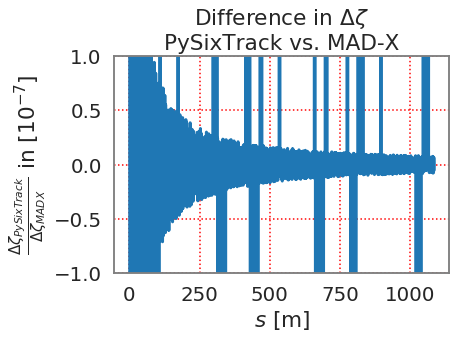

In [92]:
plt.plot(s_interp, 1e7 * (
    (zeta_pysixtrack_interp - zeta_pysixtrack_interp[0]) / (zeta_madx_interp - zeta_madx_interp[0]) - 1) )
# plt.axhline((particles.rvv - 1) * 100, color='red')
# plt.text(-30, 0.03, r'$\frac{\beta_i}{\beta_0}=%.5f$'%(particles.rvv), color='red', 
#          fontsize=28, va='top', bbox=dict(facecolor='white', alpha=0.8))
plt.ylim(-1, 1)
plt.xlabel('$s$ [m]')
plt.ylabel(r'$\frac{\Delta\zeta_{PySixTrack}}{\Delta\zeta_{MADX}}$ in $[10^{-7}]$')
plt.title(r'Difference in $\Delta\zeta$' + '\nPySixTrack vs. MAD-X');

## PySixTrack running for 20k turns with RF on to compare to MAD-X:

In [93]:
madx.input('cavity_voltage = 58.2/1000/number_cavities;')

True

In [94]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    madx.sequence.sis100ring, exact_drift=True, install_apertures=install_apertures
)

In [95]:
# pysixtrack_particles = pysixtrack.Particles(npart, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

# assert npart == 1
# pysixtrack_particles.x = pyht_beam.x[0]
# pysixtrack_particles.px = pyht_beam.xp[0]
# pysixtrack_particles.y = pyht_beam.y[0]
# pysixtrack_particles.py = pyht_beam.yp[0]
# pysixtrack_particles.zeta = pyht_beam.z[0]
# pysixtrack_particles.delta = pyht_beam.dp[0]
# # all other coordinates are correctly set in PySixTrack

madx.command.readtable(file="track_noSpch4_one", table="tracksumm")

pysixtrack_particles = pysixtrack.Particles.from_madx_track(madx)

Want to make named table: tracksumm


In [96]:
# pysixtrack_particles._p0c = p0c
# pysixtrack_particles._mass0 = mass / e * c**2

# necessary to transfer to SixTrackLib with this version of PySixTrack
pysixtrack_particles.state = np.ones_like(pysixtrack_particles.x)
pysixtrack_particles.state[1:] = 0
pysixtrack_particles.elemid = 0

pysixtrack_particles.remove_lost_particles()

In [97]:
pysixtrack_particles_frommadx = pysixtrack_particles

In [98]:
pysixtrack_particles = pysixtrack.Particles(npart, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

assert npart == 1
pysixtrack_particles.x = pysixtrack_particles_frommadx.x
pysixtrack_particles.px = pysixtrack_particles_frommadx.px
pysixtrack_particles.y = pysixtrack_particles_frommadx.y
pysixtrack_particles.py = pysixtrack_particles_frommadx.py
pysixtrack_particles.zeta = pysixtrack_particles_frommadx.zeta
pysixtrack_particles.delta = pysixtrack_particles_frommadx.delta

In [99]:
x_pysixtrack = np.zeros(nturns)
zeta_pysixtrack = np.zeros_like(x_pysixtrack)
delta_pysixtrack = np.zeros_like(x_pysixtrack)

t0 = time.time()
for turn in range(nturns):
    pysixtrack_elements.track(pysixtrack_particles)
    x_pysixtrack[turn] = pysixtrack_particles.x
    zeta_pysixtrack[turn] = pysixtrack_particles.zeta
    delta_pysixtrack[turn] = pysixtrack_particles.delta
t1 = time.time()

In [100]:
(t1 - t0) / 60.

57.02297673622767

(10000, 10100)

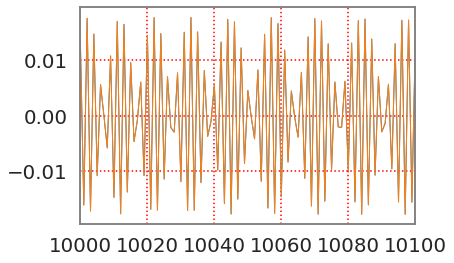

In [101]:
plt.plot(x_pysixtrack[0::npart], lw=1)
plt.plot(p_all_here[1:, headers.index('X')], lw=1)
plt.xlim(10000, 10100)

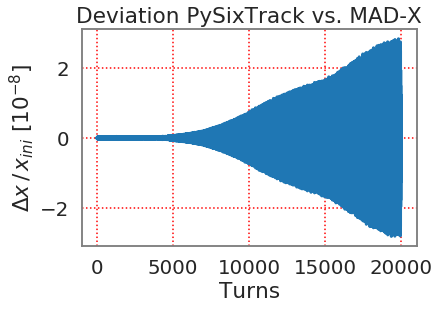

In [102]:
plt.plot((x_pysixtrack[0::npart] - p_all_here[1:, headers.index('X')]) / x_pysixtrack[0] * 1e8)
plt.xlabel('Turns')
plt.ylabel(r'$\Delta x \,/\, x_{ini}$ [$10^{-8}$]')
plt.title('Deviation PySixTrack vs. MAD-X');

In [103]:
tau_madx = p_all_here[1:, headers.index('T')]
ptau_madx = p_all_here[1:, headers.index('PT')]
zeta_madx = tau_madx * get_betai(ptau_madx)

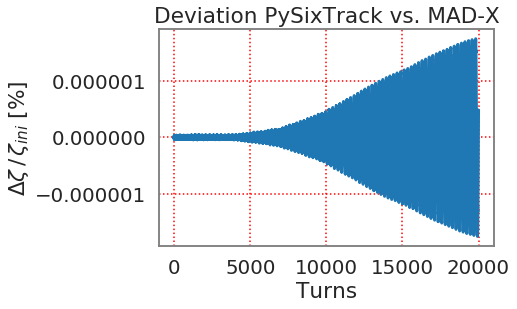

In [104]:
plt.plot(
    (zeta_pysixtrack[0::npart] - zeta_madx) / zeta_pysixtrack[0] * 100)
#     (tau_pysixtrack[0::npart] - tau_madx) / tau_pysixtrack[0] * 100)
plt.xlabel('Turns')
plt.ylabel(r'$\Delta \zeta \,/\, \zeta_{ini}$ [%]')
# plt.ylabel(r'$\Delta \tau \,/\, \tau_{ini}$ [%]')
plt.title('Deviation PySixTrack vs. MAD-X');

In [105]:
delta_madx = ptau_madx / get_betai(ptau_madx)

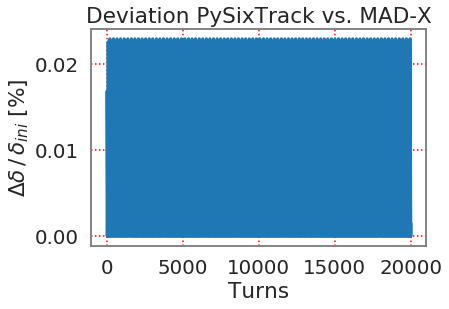

In [106]:
plt.plot((delta_pysixtrack[0::npart] - delta_madx) / delta_pysixtrack[0] * 100)
plt.xlabel('Turns')
plt.ylabel(r'$\Delta \delta \,/\, \delta_{ini}$ [%]')
plt.title('Deviation PySixTrack vs. MAD-X');
# plt.xlim(0, 100)
# plt.ylim(-1e-6, 1e-6)

# `get_betai` WORKS!

MAD-X `PT` is identical to SixTrackLib and PySixTrack `ptau`.

So we can directly test:

In [107]:
get_betai(pysixtrack_particles.ptau[0]) == pysixtrack_particles.beta[0]

True

I.e. in PySixTrack the `get_betai` function works and yields the same as the internally computed `beta`. How about SixTrackLib?

In [108]:
get_betai(particles.ptau[0]) == particles.beta[0]

True